# Task 1 - The Classical Computer Vision Baseline

## Loading data

The dataset is downloaded and located in the "NEU-DET" folder. The dataset can be loaded in a pandas dataframe, where we store the filepath, type and id of each image. We can split the dataset 80/20 into a training set and a validation set. 

In [1]:
# folder: ./NEU-DET/train/

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# we have to loop through NEU-DET/train/{all 6 folders} and add the filepaths of all images inside
image_list = []
path_train = '../NEU-DET/train/images'
path_validation = '../NEU-DET/validation/images'

# get images from training
for folder in os.listdir(path_train):
    for file in os.listdir(os.path.join(path_train, folder)):
        image_list.append({'filepath': os.path.join(path_train, folder, file), 'type': file.split('_')[0], 'id': file.split('_')[-1].split('.')[0]})

# get images from validation
for folder in os.listdir(path_validation):
    for file in os.listdir(os.path.join(path_validation, folder)):
        image_list.append({'filepath': os.path.join(path_validation, folder, file), 'type': file.split('_')[0], 'id': file.split('_')[-1].split('.')[0]})

# create dataframe
df = pd.DataFrame(image_list)

# 80/20 split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['type'], random_state=7)

print("training set containing", len(train_df), "images: \n", train_df.head(), "\n")
print("validation set containing", len(val_df), "images: \n", val_df.head())



training set containing 1440 images: 
                                                filepath       type   id
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66 

validation set containing 360 images: 
                                                filepath       type   id
209      ../NEU-DET/train/images\crazing\crazing_71.jpg    crazing   71
1779  ../NEU-DET/validation/images\scratches\scratch...  scratches  280
629     ../NEU-DET/train/images\patches\patches_233.jpg    patches  233
604     ../NEU-DET/train/images\patches\patches_210.jpg    patches  210
1457  ../NEU-DET/validation/images\crazing\crazing_2...    crazing  258


## Visual inspection

The first step is to inspect the type of images we are working with, to determine the best feature extraction steps for later. 

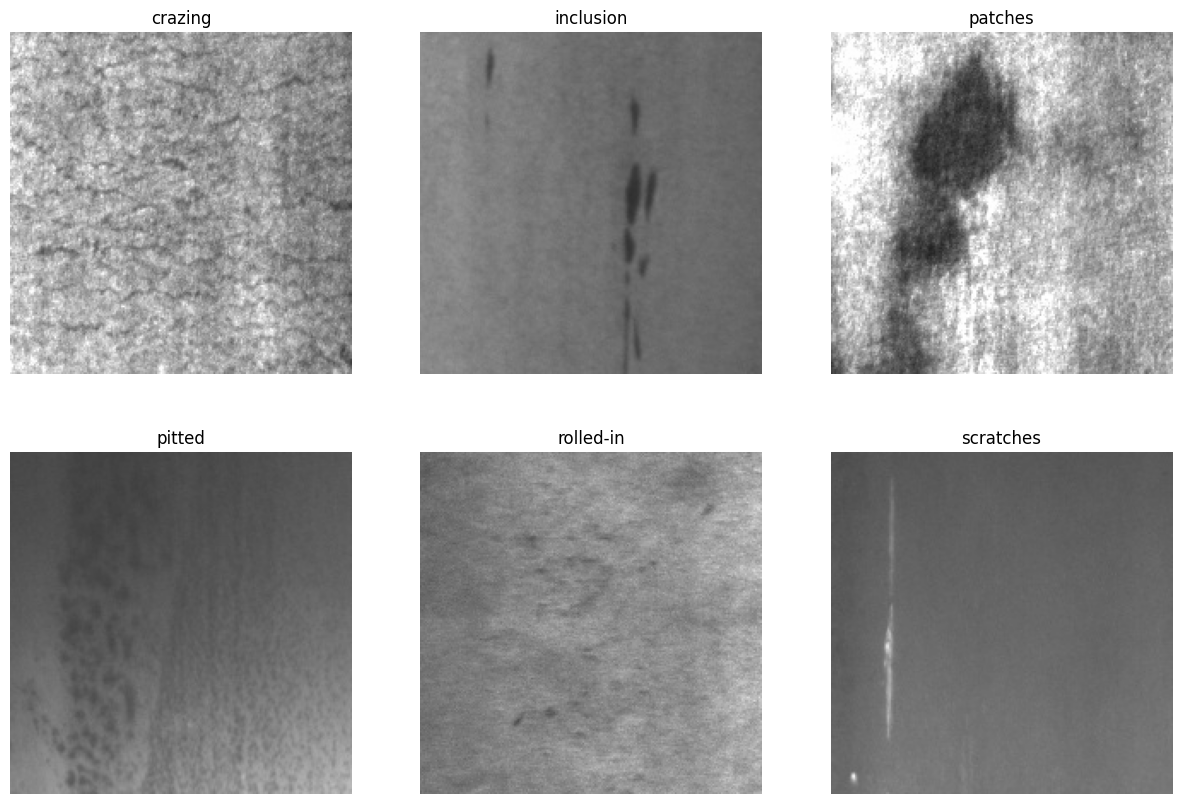

In [2]:
# get an array of the different defect types
types = df['type'].unique()

# and plot the first image of each type
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, t in enumerate(types):
    img = plt.imread(df[df['type'] == t].iloc[0]['filepath'])
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].set_title(t)
    axs[i // 3, i % 3].axis('off')
plt.show()


The figure shows one image from each defect, displaying the types of images we will be looking at.

6 types of defects are shown: 
- Crazing - network of cracks
- Inclusion - non-metallic particles entrapped 
- Patches - large regions where texture looks different
- Pitted Surface - depressions scattered across surface
- scratches - long marks
- rolled-in - layered patches adhered to the surface

All images are greyscale, and we can already guess what some of the defects are based on intensity and shape (scratches and inclusion), or by size (patches). 

The goal is to select 2 types of features to be used for classification, where one focuses on local features like edges and gradients while the other focuses on textures. For this baseline, I selected Histogram of Oriented Gradients (HOG) and Gray-Level Co-occurence Matrix (GLCM) features as HOG is well-suited for capturing local structures like edges, lines, and gradients, while GLCM provides texture-based descriptors that capture spatial relationships between pixel intensities.

For classification, I chose a Random Forest model because it efficiently handles different types of feature sets.


 




## Histogram of oriented gradients (HOG) 

First, we implement HOG using skimage. HOG captures local edge/gradient orientation. This is a good starting point and is relatively quick to implement using the df we defined earlier. To compute the HOG we will use 8x8 pixels for a cell, and 2x2 cells for a block. The extract_hog function is defined in the following dropdown.

In [3]:
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray

def extract_hog(filepath):
    img = imread(filepath)
    if img.ndim == 3:
        img = rgb2gray(img)
    features = hog(img, 
                   orientations=8, 
                   pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2)
                )
    return features


Using the extract_hog for both the training and the validation set, we can store the resulting features in the df.

In [4]:
import numpy as np

X_train = np.vstack([extract_hog(fp) for fp in train_df["filepath"]])
y_train = train_df["type"].values

X_test = np.vstack([extract_hog(fp) for fp in val_df["filepath"]])
y_test = val_df["type"].values

# add these to the dataframe as well
train_df['hog_features'] = list(X_train)
val_df['hog_features'] = list(X_test)

print("the head of the train df: \n", train_df.head())

the head of the train df: 
                                                filepath       type   id  \
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44   
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59   
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124   
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87   
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66   

                                           hog_features  
419   [0.23692369683202827, 0.15415997280614854, 0.2...  
675   [0.2932409827161144, 0.03451907966977623, 0.13...  
748   [0.25374744478784045, 0.25374744478784045, 0.2...  
226   [0.22393231707764982, 0.08401035403228327, 0.2...  
1163  [0.19847725569063174, 0.07978102076128961, 0.1...  


we can keep an eye on what sort of features we are extracting by making use of the hog_image value returned, as seen in the dropdown below.

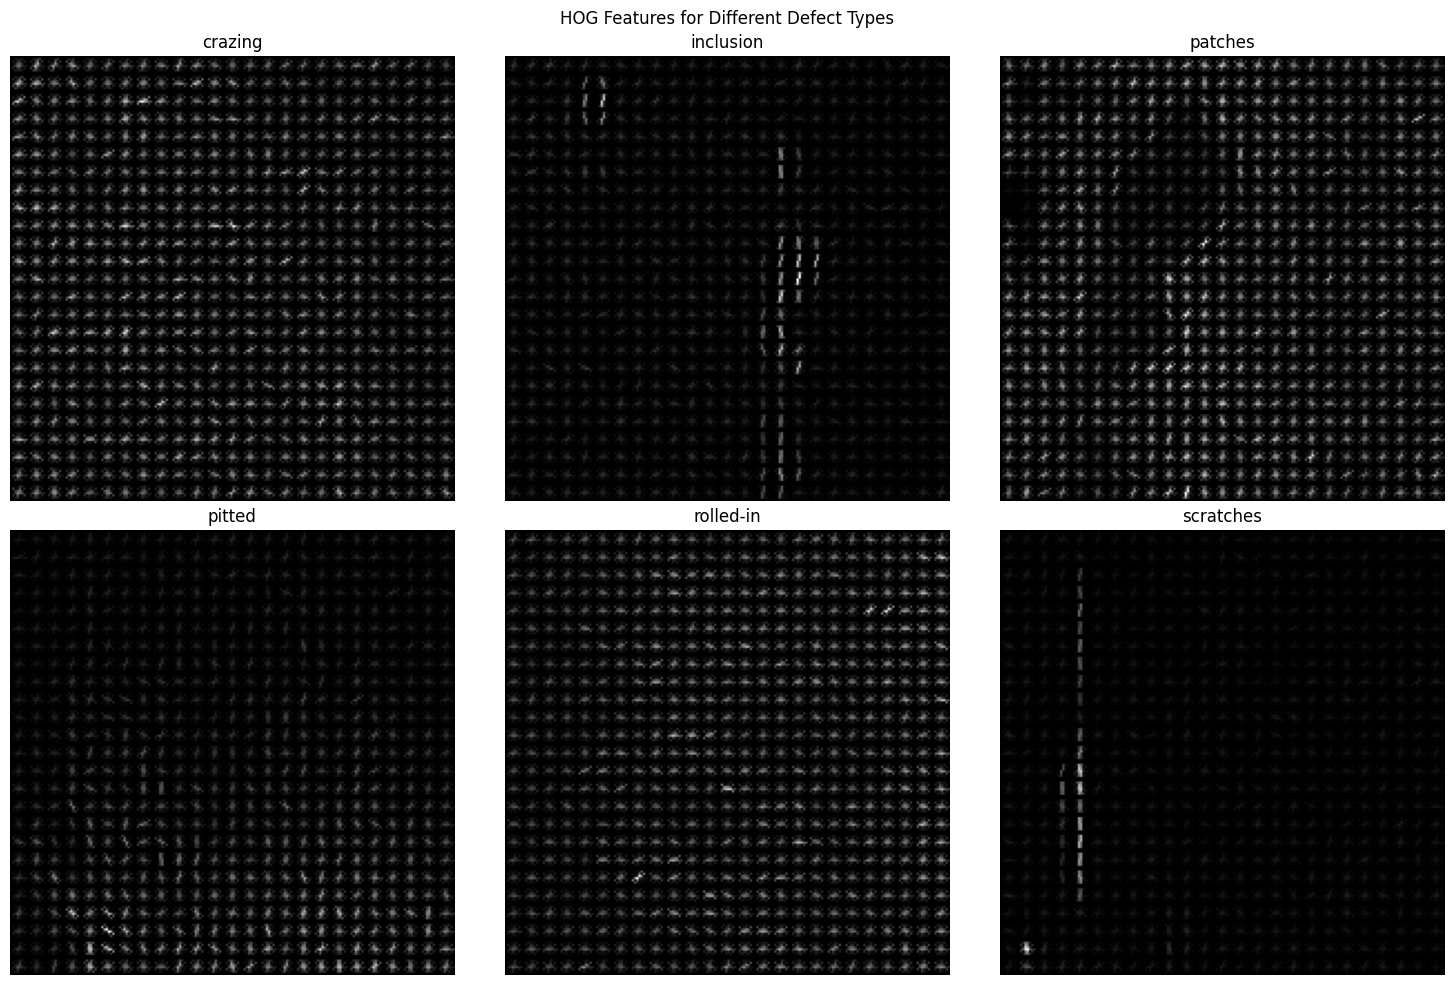

In [5]:
#| label: fig-my-plot

from skimage import exposure

# make a grid 2 rows x 3 columns (one per defect type)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, t in enumerate(types):
    # get first image for defect type
    fp = df[df['type'] == t].iloc[0]['filepath']
    img = imread(fp)
    if img.ndim == 3:
        img = rgb2gray(img)
    
    # compute HOG features with visualization
    features, hog_image = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    
    # rescale HOG image for display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))
    
    # plot HOG map
    axs[i // 3, i % 3].imshow(hog_image_rescaled, cmap='gray')
    axs[i // 3, i % 3].set_title(f"{t}")
    axs[i // 3, i % 3].axis('off')

fig.suptitle("HOG Features for Different Defect Types")
plt.tight_layout()
plt.show()

From visual inspection we can already see how the HOG features will allow a classification algorithm to easily distinguish between scratches and inclusions, and the other defects. It will also be expected to lack information regarding the other individual defects as they look quite similar.

## Classification - Random Forest

To classify the images, we will use Random Forest (RF) classification. As RF is based on a decision tree, there are few parameters to tune which is ideal for an experimental-based task like we are doing now. We can implement a RF classifier using 200 estimators and random_state = 1 to get similar results on each run: 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels from the DataFrames
X_rf_train = np.vstack(train_df['hog_features'].values)
y_rf_train = train_df['type'].values

X_rf_val = np.vstack(val_df['hog_features'].values)
y_rf_val = val_df['type'].values

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=1)
rf.fit(X_rf_train, y_rf_train)

# Predict on validation set
y_pred = rf.predict(X_rf_val)

# Print accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_rf_val, y_pred))
print("classification report: \n", classification_report(y_rf_val, y_pred))

Validation Accuracy: 0.7222222222222222
classification report: 
               precision    recall  f1-score   support

     crazing       0.67      0.90      0.77        60
   inclusion       0.68      0.82      0.74        60
     patches       0.60      0.42      0.49        60
      pitted       0.65      0.58      0.61        60
   rolled-in       0.94      1.00      0.97        60
   scratches       0.79      0.62      0.69        60

    accuracy                           0.72       360
   macro avg       0.72      0.72      0.71       360
weighted avg       0.72      0.72      0.71       360



A confusion matrix can be generated using the validation set, visualising ...

In [7]:
cm = confusion_matrix(y_rf_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         54          0        6       0          0          0
inclusion        0         49        0       6          0          5
patches         21          0       25      13          0          1
pitted           5          5       11      35          0          4
rolled-in        0          0        0       0         60          0
scratches        1         18        0       0          4         37


## Sanity check: mid-point evaluation

Based on the classification using just the HOG feature, we can see where the RF model makes mistakes. This allows us to more accurately determine the second feature we can use to increase the accuracy. 

First to note is the poor performance recognising the difference between pitted surfaces and patches. This is most likely due to the HOG features only containing information about gradients, and less about broader shapes and sizes. 

We can add Grey-level Co-occurance Matrix (GLCM) features to try and supplement the HOG features. GLCM counts how often pairs of pixel intensities occur at a given distance and direction, turning those co-occurrence patterns into texture descriptors. 

## Gray-Level Co-occurrence Matrix (GLCM)

We can also implement GLCM using the skimage library. We define a GLCM function with preset distances [1,2,4,8] and angles [0, np.pi/4, np.pi/2, 3*np.pi/4]: 

In [8]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
import numpy as np

# function to extract GLCM features, 
def extract_glcm(filepath, distances=[1,2,4,8], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):

    img = imread(filepath)
    if img.ndim == 3:
        img = rgb2gray(img)
    
    # Convert to 8-bit grayscale (0-255)
    img = (img * 255).astype(np.uint8)
    
    # Compute GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Extract features
    feats = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        vals = graycoprops(glcm, prop)
        feats.extend(vals.flatten())
    
    return np.array(feats)

This function can be applied to each image in the dataset

In [9]:
# Training set
X_glcm_train = np.vstack([extract_glcm(fp) for fp in train_df['filepath']])
train_df['glcm_features'] = list(X_glcm_train)

# Validation/test set
X_glcm_val = np.vstack([extract_glcm(fp) for fp in val_df['filepath']])
val_df['glcm_features'] = list(X_glcm_val)

print("all images processed, head of train df: \n", train_df.head())

all images processed, head of train df: 
                                                filepath       type   id  \
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44   
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59   
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124   
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87   
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66   

                                           hog_features  \
419   [0.23692369683202827, 0.15415997280614854, 0.2...   
675   [0.2932409827161144, 0.03451907966977623, 0.13...   
748   [0.25374744478784045, 0.25374744478784045, 0.2...   
226   [0.22393231707764982, 0.08401035403228327, 0.2...   
1163  [0.19847725569063174, 0.07978102076128961, 0.1...   

                                          glcm_features  
419   [12.780653266331631, 17.25441276735443, 8.2350...  
675   [307.57419597989616, 426.07954

## Classification - Random Forrest

Run the RF classification algorithm again, this time using both the HOG features and the GLCM features. This results in the following classification report: 

In [10]:
# Concatenate HOG + GLCM for each image
X_train_combined = np.vstack([
    np.hstack((hog_feat, glcm_feat))
    for hog_feat, glcm_feat in zip(train_df['hog_features'], train_df['glcm_features'])
])

X_val_combined = np.vstack([
    np.hstack((hog_feat, glcm_feat))
    for hog_feat, glcm_feat in zip(val_df['hog_features'], val_df['glcm_features'])
])

# Labels
y_train = train_df['type'].values
y_val = val_df['type'].values

# Initialize RF (class_weight='balanced' is optional if some classes are rarer)
rf = RandomForestClassifier(n_estimators=100, random_state=1)

# Train
rf.fit(X_train_combined, y_train)

# Predict on validation set
y_pred = rf.predict(X_val_combined)

# Print accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# add classification report to df  
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()



Validation Accuracy: 0.8972222222222223
              precision    recall  f1-score   support

     crazing       0.91      0.85      0.88        60
   inclusion       0.82      0.97      0.89        60
     patches       0.85      0.92      0.88        60
      pitted       0.88      0.77      0.82        60
   rolled-in       1.00      1.00      1.00        60
   scratches       0.95      0.88      0.91        60

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



With the following confusion matrix: 

In [11]:
# get confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         51          0        8       1          0          0
inclusion        0         58        0       1          0          1
patches          1          0       55       4          0          0
pitted           4          6        2      46          0          2
rolled-in        0          0        0       0         60          0
scratches        0          7        0       0          0         53


In [12]:
# how many input features for RF
print("Number of input variables for RF:", X_train_combined.shape[1])

Number of input variables for RF: 18512


## Conclusion Task 1

After the sanity check we have successfully improved the model by also looking at the GLCM features. The model now more accurately distinguishes between patches and pitted surfaces. The overall precision increased from an average of 0.72 to an average of 0.90. While small discrepancies remain, there is no recurring error for a specific class. For each of the classes, the F1-Score is quite similar to the precision and the recall, indicating the model neither over-predicts nor under-predicts. This shows the model is making balanced predictions for all defect types.

### sidenote

The below code has been run to analyse and select 3 images to be displayed in task 3. This code does not run in the MYST book, only when opened as a notebook. 

In [13]:
# generate an interactive plot, where we can scroll through all misclassified images and see what index they are at
import ipywidgets as widgets
from IPython.display import display

# get indices of misclassified images
misclassified_indices = np.where(y_val != y_pred)[0]

# interactive function to display image and its info
def show_image(index):
    if index < 0 or index >= len(misclassified_indices):
        print("Index out of range")
        return
    actual_index = misclassified_indices[index]
    img = imread(val_df.iloc[actual_index]['filepath'])
    plt.imshow(img, cmap='gray')
    plt.title(f"Index: {actual_index}, Actual: {y_val[actual_index]}, Predicted: {y_pred[actual_index]}")
    plt.axis('off')
    plt.show()
slider = widgets.IntSlider(value=0, min=0, max=len(misclassified_indices)-1, step=1, description='Image Index:')
widgets.interact(show_image, index=slider)

# 9 - big dark patches
# 11 - scratches/inclusion
# 21


interactive(children=(IntSlider(value=0, description='Image Index:', max=36), Output()), _dom_classes=('widget…

<function __main__.show_image(index)>

Selecting images based on the challenges we want to focus on: 
1) patch classified as pitted - very little detail can be seen, repeating dark pattern
2) scratch classified as inclusion - similar to the model in task 2
3) pitted classified as inclusion - a lot is going on, with both features and a general gradient in light

In [14]:
# make a new df of misclassified images indices 9 11 and 21
actual_indices = misclassified_indices[[9, 11, 21]].copy()
misclassified_df_1 = val_df.iloc[actual_indices]
misclassified_df_1['predicted_type'] = y_pred[actual_indices]
print("head of misclassified df 1: \n", misclassified_df_1.head())


head of misclassified df 1: 
                                                filepath       type   id  \
612     ../NEU-DET/train/images\patches\patches_218.jpg    patches  218   
1413  ../NEU-DET/train/images\scratches\scratches_75...  scratches   75   
1678  ../NEU-DET/validation/images\pitted_surface\pi...     pitted  299   

                                           hog_features  \
612   [0.21932371115818358, 0.09558774847063646, 0.2...   
1413  [0.24390883623484602, 0.09511208720764543, 0.1...   
1678  [0.2721780013468988, 0.13395665865737882, 0.27...   

                                          glcm_features predicted_type  
612   [61.800226130649676, 81.08113431479374, 47.461...         pitted  
1413  [14.27389447236167, 17.152622408525247, 6.0829...      inclusion  
1678  [2.9243216080401897, 4.711749703290347, 3.0455...      inclusion  


C:\Users\luukf\AppData\Local\Temp\ipykernel_8760\208264479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df_1['predicted_type'] = y_pred[actual_indices]


# Task 2 - The Modern Hybrid Baseline

We will load a pretrained CNN (resnet18) and remove the final classification layer. This allows us to extract a feature map consisting of 512 values. 

## Load data and model

First, we import the ResNet18 model. ResNet18 offers a strong trade-off between depth and efficiency, making it more effective than shallow models and less computationally demanding than very deep architectures like ResNet50. If necessary, we can also upgrade to ResNet50 once GPU access is approved ;)

In [15]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # parameter 'pretrained' is deprecated
print("model loaded correctly: \n", model)

model loaded correctly: 
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re


The pytorch [website](https://docs.pytorch.org/vision/0.8/models.html) states 

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

which has been implemented in the following way, while we also remove the final classification layer 

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects at least 224x224
    transforms.ToTensor(),           # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Remove the final classification layer, keep everything up to the penultimate
model = nn.Sequential(*list(model.children())[:-1])  # outputs [batch, 512, 1, 1]
model.eval()

print("The model used to extract features from the input images is: \n", model)



The model used to extract features from the input images is: 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

## Run model

We can run the model by applying an 'extract_resnet_features' function to each path in the df:

In [17]:
from PIL import Image

# helper function to extract features from a single image
def extract_resnet_features(filepath, model, transform, device="cpu"):
    img = Image.open(filepath).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        features = model(img_t)  # shape [1, 512, 1, 1]
    return features.squeeze().cpu().numpy()  # -> (512,)

# Only CPU available on my machine :(
device = "cpu"
model.to(device)

# Extract features using helper function and add to dataframe
train_df["resnet_features"] = train_df["filepath"].apply(
    lambda fp: extract_resnet_features(fp, model, transform, device)
)
val_df["resnet_features"] = val_df["filepath"].apply(
    lambda fp: extract_resnet_features(fp, model, transform, device)
)

## Classification - Random Forest

Just like in task 1, we can use these features to train a RF classifier. Using 200 estimators and a random state equal to 1 for reproducibility gives the following results for the validation set:

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = np.vstack(train_df["resnet_features"])
y_train = train_df["type"].values

X_val = np.vstack(val_df["resnet_features"])
y_val = val_df["type"].values

clf = RandomForestClassifier(n_estimators=200, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     crazing       1.00      1.00      1.00        60
   inclusion       0.95      1.00      0.98        60
     patches       1.00      1.00      1.00        60
      pitted       1.00      1.00      1.00        60
   rolled-in       1.00      1.00      1.00        60
   scratches       1.00      0.95      0.97        60

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



With the following confusion matrix

In [19]:
# get confusion matrix
from sklearn.metrics import confusion_matrix

types = np.unique(y_train)

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         60          0        0       0          0          0
inclusion        0         60        0       0          0          0
patches          0          0       60       0          0          0
pitted           0          0        0      60          0          0
rolled-in        0          0        0       0         60          0
scratches        0          3        0       0          0         57


In [20]:
classification_report_df = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).transpose()

## Conclusion Task 2

The score has significantly improved for all defects compared to the model from task 1. In the validation set, 5% of scratches have been labeled as inclusions (3 images) which are the only mistakes made by the model.

Number of misclassified images: 3 out of 60


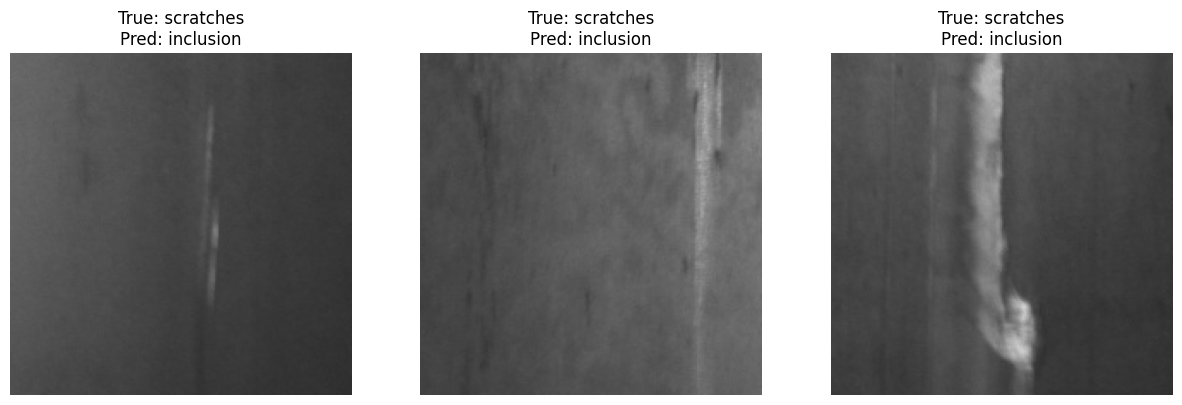

In [21]:
# find example of misclassified images
import matplotlib.pyplot as plt
misclassified_indices = np.where(y_val != y_pred)[0]

# get number of misclassified images
num_misclassified = len(misclassified_indices)
print(f"Number of misclassified images: {num_misclassified} out of {len(y_val)//6}")

# plot all misclassified images in a row
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices):
    img = Image.open(val_df.iloc[idx]["filepath"]).convert("RGB")
    plt.subplot(1, num_misclassified, i + 1)
    plt.imshow(img)
    plt.title(f"True: {y_val[idx]}\nPred: {y_pred[idx]}")
    plt.axis('off')
plt.show()



The image above shows the 3 mislabel images. Upon visual inspection, there are other factors which might confuse the model, like darker streaks through the image or a curved lighter area. 

The code below saves any relevant information to be used in task 3.

In [22]:
# generate df with misclassified images
misclassified_df_2 = val_df.iloc[misclassified_indices].copy()
# add what it was misclassified as
misclassified_df_2['predicted_type'] = y_pred[misclassified_indices]

print("head of misclassified df: \n", misclassified_df_2.head())

head of misclassified df: 
                                                filepath       type   id  \
1367  ../NEU-DET/train/images\scratches\scratches_33...  scratches   33   
1436  ../NEU-DET/train/images\scratches\scratches_96...  scratches   96   
1255  ../NEU-DET/train/images\scratches\scratches_14...  scratches  149   

                                           hog_features  \
1367  [0.24386450299027249, 0.04930528793305931, 0.1...   
1436  [0.2586998781411621, 0.2586998781411621, 0.145...   
1255  [0.24895916728046874, 0.12257607278528368, 0.0...   

                                          glcm_features  \
1367  [3.8329648241205674, 5.077195020327808, 2.3092...   
1436  [10.712135678391716, 13.830812353223765, 4.713...   
1255  [15.718442211054729, 17.360899977273984, 5.221...   

                                        resnet_features predicted_type  
1367  [0.4007034, 0.0003153183, 0.0, 3.752021, 0.074...      inclusion  
1436  [0.6261164, 0.06544557, 0.19352002, 2.2963228

# Task 3 - Synthesis and Recommendations

In this task we will discuss the performances of both models, the types of errors made and recommendations for future development. Throughout the task, I will refer to the model combining HOG and GLCM feature extraction with a RF classifier designed in task 1 as model 1. I will refer to the pre-trained ResNet18 model with a Random Forest classifier as model 2.

## Comparative Analysis
Model 2, which combines the pre-trained ResNet18 with a Random Forest classifier, performs significantly better at recognizing all defects than Model 1, which uses HOG and GLCM feature extraction with a Random Forest classifier. The average precision of Model 2 is 0.99, compared to 0.90 for Model 1. 

One reason is the types of features extracted by the ResNet18 model. The model consists of multiple convolutional layers, which allows the extraction of hierarchical and multi-scale features such as fine textures, local shapes, and repeated patterns. The model designed in task 1, on the other hand, makes use of only two distinct feature types, HOG and GLCM, which primarily capture edges, gradients, and simple textural statistics, limiting the ability of the classifier to distinguish more subtle or complex defects.

The ResNet18 model has been trained on a large dataset, (ImageNet), which contains over 1.2 million images across 1,000 classes. This exposure allows the model to learn a wide variety of visual patterns, from simple edges to complex textures and object structures. As a result, even when applied to grayscale steel surface images, the model can extract rich and generalizable features that help the Random Forest classifier distinguish between different types of defects more effectively than handcrafted features alone.

I would also like to note that the RF classifier in task 1 is trained using 18,512 input features, while the RF classifier in task 2 is trained using only 512 input features. The fact that model 2 achieves higher precision demonstrates how curated and informative the ResNet-derived features are, with the ResNet part of the model effectively performing high-level preprocessing before classification.

## Error Analysis

### Model 1

First, for model 1 I have picked the following 3 images:

In [23]:
print(misclassified_df_1.head(), len(misclassified_df_1))

                                               filepath       type   id  \
612     ../NEU-DET/train/images\patches\patches_218.jpg    patches  218   
1413  ../NEU-DET/train/images\scratches\scratches_75...  scratches   75   
1678  ../NEU-DET/validation/images\pitted_surface\pi...     pitted  299   

                                           hog_features  \
612   [0.21932371115818358, 0.09558774847063646, 0.2...   
1413  [0.24390883623484602, 0.09511208720764543, 0.1...   
1678  [0.2721780013468988, 0.13395665865737882, 0.27...   

                                          glcm_features predicted_type  
612   [61.800226130649676, 81.08113431479374, 47.461...         pitted  
1413  [14.27389447236167, 17.152622408525247, 6.0829...      inclusion  
1678  [2.9243216080401897, 4.711749703290347, 3.0455...      inclusion   3


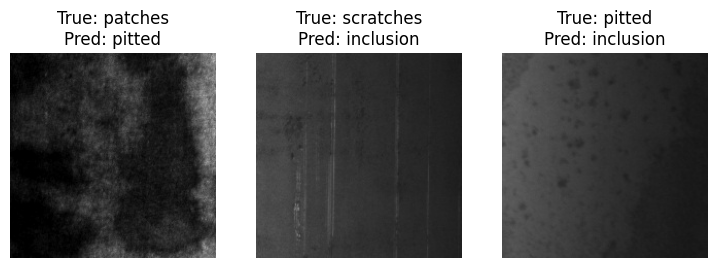

In [24]:
# create a figure with enough width for all images
plt.figure(figsize=(3 * len(misclassified_df_1), 4))

for idx, (i, row) in enumerate(misclassified_df_1.iterrows()):  # idx is 0,1,2,...
    img = Image.open(row["filepath"]).convert("RGB")
    plt.subplot(1, len(misclassified_df_1), idx + 1)  # use idx, not i
    plt.imshow(img)
    plt.title(f"True: {row['type']}\nPred: {row['predicted_type']}")
    plt.axis('off')

plt.show()

which all depict different 'problems' regarding the model. 
1) Patches which are classified as a pitted-surface. This mistake can be due to the stepsize used to collect the GLCM features, where the largest stepsize of 8 might not provide enough distance to properly contextualise the defect. 
2) Scratches classified as inclusions. This is a classification error also hard to spot by eye. We will see model 2 equally struggle with this. This is most likely due to both defects consisting of straight, high contrast lines. 
3) A pitted-surface clasified as an inclusion. This misclassification can reasonably be due to the low image quality, with a general gradient between the upper left corner and lower right corner. The HOG feature might have picked up a gradient line, which can easily be classified as an inclusion. 

### Model 2

For the model from task 2, there are only 3 mistakes in classification. For each image, a scratch is classified as an inclusion. 

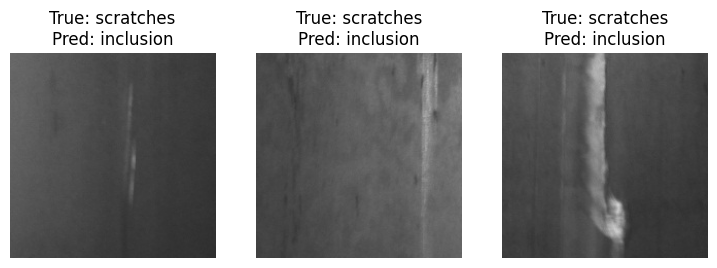

In [25]:
# create a figure with enough width for all images
plt.figure(figsize=(3 * len(misclassified_df_2), 4))

for idx, (i, row) in enumerate(misclassified_df_2.iterrows()):  # idx is 0,1,2,...
    img = Image.open(row["filepath"]).convert("RGB")
    plt.subplot(1, len(misclassified_df_2), idx + 1)  # use idx, not i
    plt.imshow(img)
    plt.title(f"True: {row['type']}\nPred: {row['predicted_type']}")
    plt.axis('off')

plt.show()


To visualise the difference between images showing scratches and images showing inclusions, we can display 10 images from the dataset

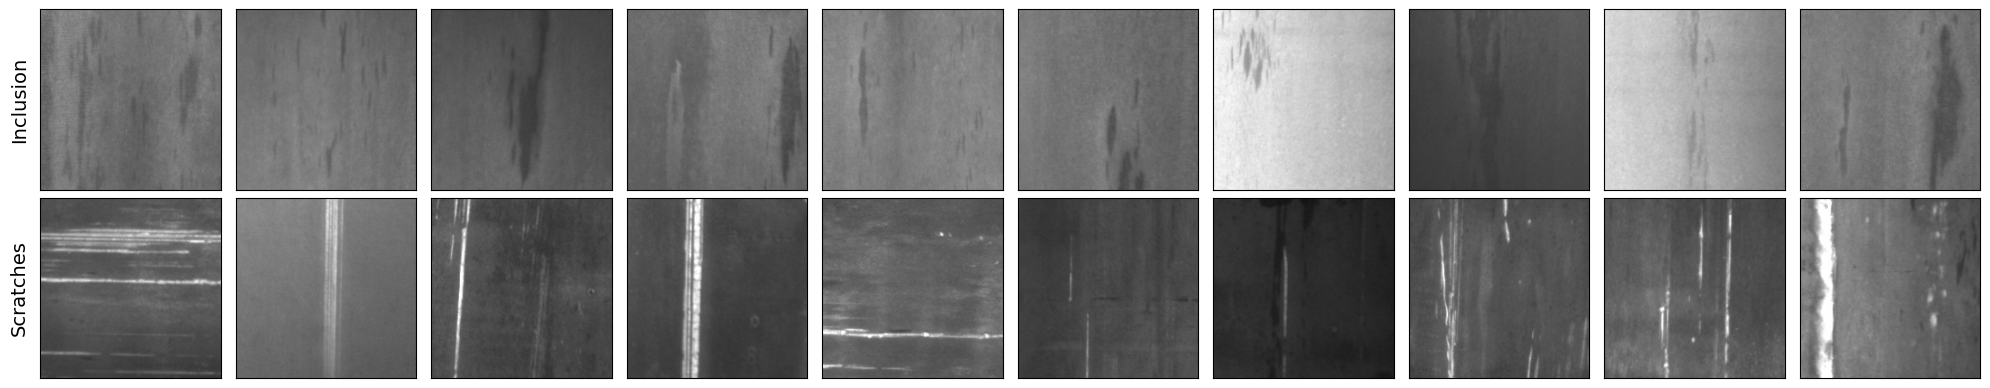

In [26]:
# Get 10 inclusions and 10 scratches from val_df
inclusion_images = val_df[val_df["type"] == "inclusion"].head(10)
scratch_images = val_df[val_df["type"] == "scratches"].head(10)

all_images = [inclusion_images, scratch_images]
all_labels = ["Inclusion", "Scratches"]

# Create figure (from matplotlib documentation)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for row_idx, (images, label) in enumerate(zip(all_images, all_labels)):
    for col_idx, filepath in enumerate(images["filepath"]):
        img = Image.open(filepath)
        axs[row_idx, col_idx].imshow(img, cmap='gray')
        # Hide ticks but keep label
        axs[row_idx, col_idx].set_xticks([])
        axs[row_idx, col_idx].set_yticks([])

    # Set vertical row label on leftmost subplot
    axs[row_idx, 0].set_ylabel(label, fontsize=14, rotation=90, labelpad=15, va='center')

plt.tight_layout()
plt.show()

Again, both defects can be recognised by long streaks in a relatively straight line. It is highly likely the ResNet model, which consists of multiple convolution layers, recognises some of these features as similar. 

One interesting thing to note, is how in this subset of the data, inclusions seem to have a darker colour than the surroundings, while scratches appear lighter. This can be used for a further experiment to try and distinguish the 2 types of defects.

To summarise: Model 2, with its more comprehensive feature representation, is better able to classify defects. Both models, however, still have difficulty distinguishing between scratches and inclusions.

## Future Strategy & Next Steps

### Future Strategy 

The first experiment I would recommend with GPU access, is to append a new classification layer to the ResNet18 model which we can train using our own data. By training the model to our own dataset, the features will be more curated to the type of images we provide. This is a tried and tested method (as done [here](https://medium.com/@imabhi1216/fine-tuning-a-pre-trained-resnet-18-model-for-image-classification-on-custom-dataset-with-pytorch-02df12e83c2c#bcd2)).

Next, I would add a seventh class to the dataset consisting of images without any defects. The current model can classify the type of defect, but ideally, a camera should be able to automatically detect whether a defect is present and then classify its type. If we do not have direct access to the camera, as in this scenario, we can use parts of the surfaces adjacent to scratches, and the subimages can be cropped or resized to the correct dimensions for the model.

Finally, using the PyTorch library we can easily choose from a [range of models](https://docs.pytorch.org/vision/stable/models.html#torchvision.models.resnet18) to use for this application. One of which is the ResNet50 model, which has a deeper architecture than ResNet18, allowing it to extract more complex features. alternatively, we could use a different model which might be trained on images similar to the images in our dataset.  

It's important to note that it would be best to increase the amount of training and validation data to see how the model would perform over a broader range of images. 

### Data Augmentation

As mentioned in the error analysis for Model 1, some images may be misclassified due to poor image quality. One way to fix this could be to manually apply small gradients or intensity variations to the images to generate new data with similar properties. 

When looking at the 10 samples of inclusion defects, all inclusions are oriented in a vertical direction. It could be interesting to explore wether this is true for the entire dataset, and if so we can generate additional training data by rotating these images. 

Depending on the broader context of how the model will be used in production, we can also look at self-supervised learning. [This paper](https://www.oaepublish.com/articles/jmi.2025.21) refers to the same dataset and shows that defects can be detected effectively using unlabeled data, reducing the need for manual annotation.


